# Predictive Maintenance with Azure Dataset

## Project imports

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Data Imports

Needs pre-processing.ipynb to be run first

In [14]:
def read(name: str, parse_dates: list[str] | None = ["datetime"]) -> pd.DataFrame:
    path = "data/"
    ext = ".csv"
    file = path + name + ext
    return pd.read_csv(file, parse_dates=parse_dates, na_values="NaN")

VARIABLES = ["volt", "rotate", "pressure", "vibration"]
DATA = read("raw_data").dropna(subset=VARIABLES)
normal_behavior_data = read("preprocessing/expected_behavior")
abnormal_data = read("preprocessing/failures_only")

## Graphs for full dataset

### Expected behavior and anomaly comparison

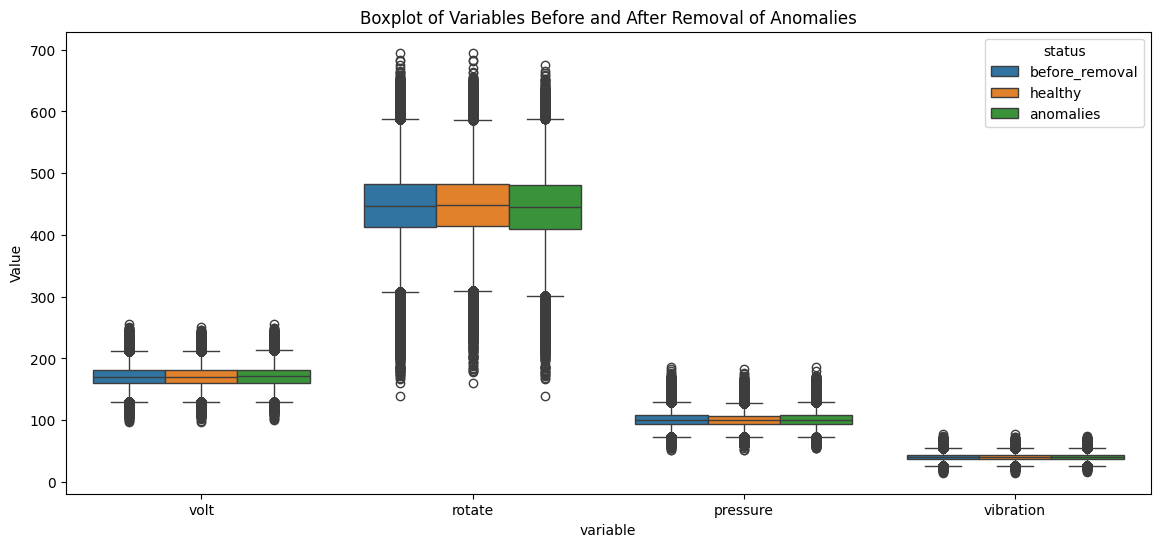

In [15]:
full_data = DATA.copy()
full_data["status"] = "before_removal"
normal_behavior_data["status"] = "healthy"
abnormal_data["status"] = "anomalies"

# Combine the two DataFrames
combined_data = pd.concat([full_data, normal_behavior_data, abnormal_data])

# Melt the DataFrame
melted_data = pd.melt(
    combined_data, id_vars=["machineID", "status"], value_vars=VARIABLES
)

# Create the boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(x="variable", y="value", hue="status", data=melted_data)
plt.title("Boxplot of Variables Before and After Removal of Anomalies")
plt.ylabel("Value")
plt.show()

### Distribution of data

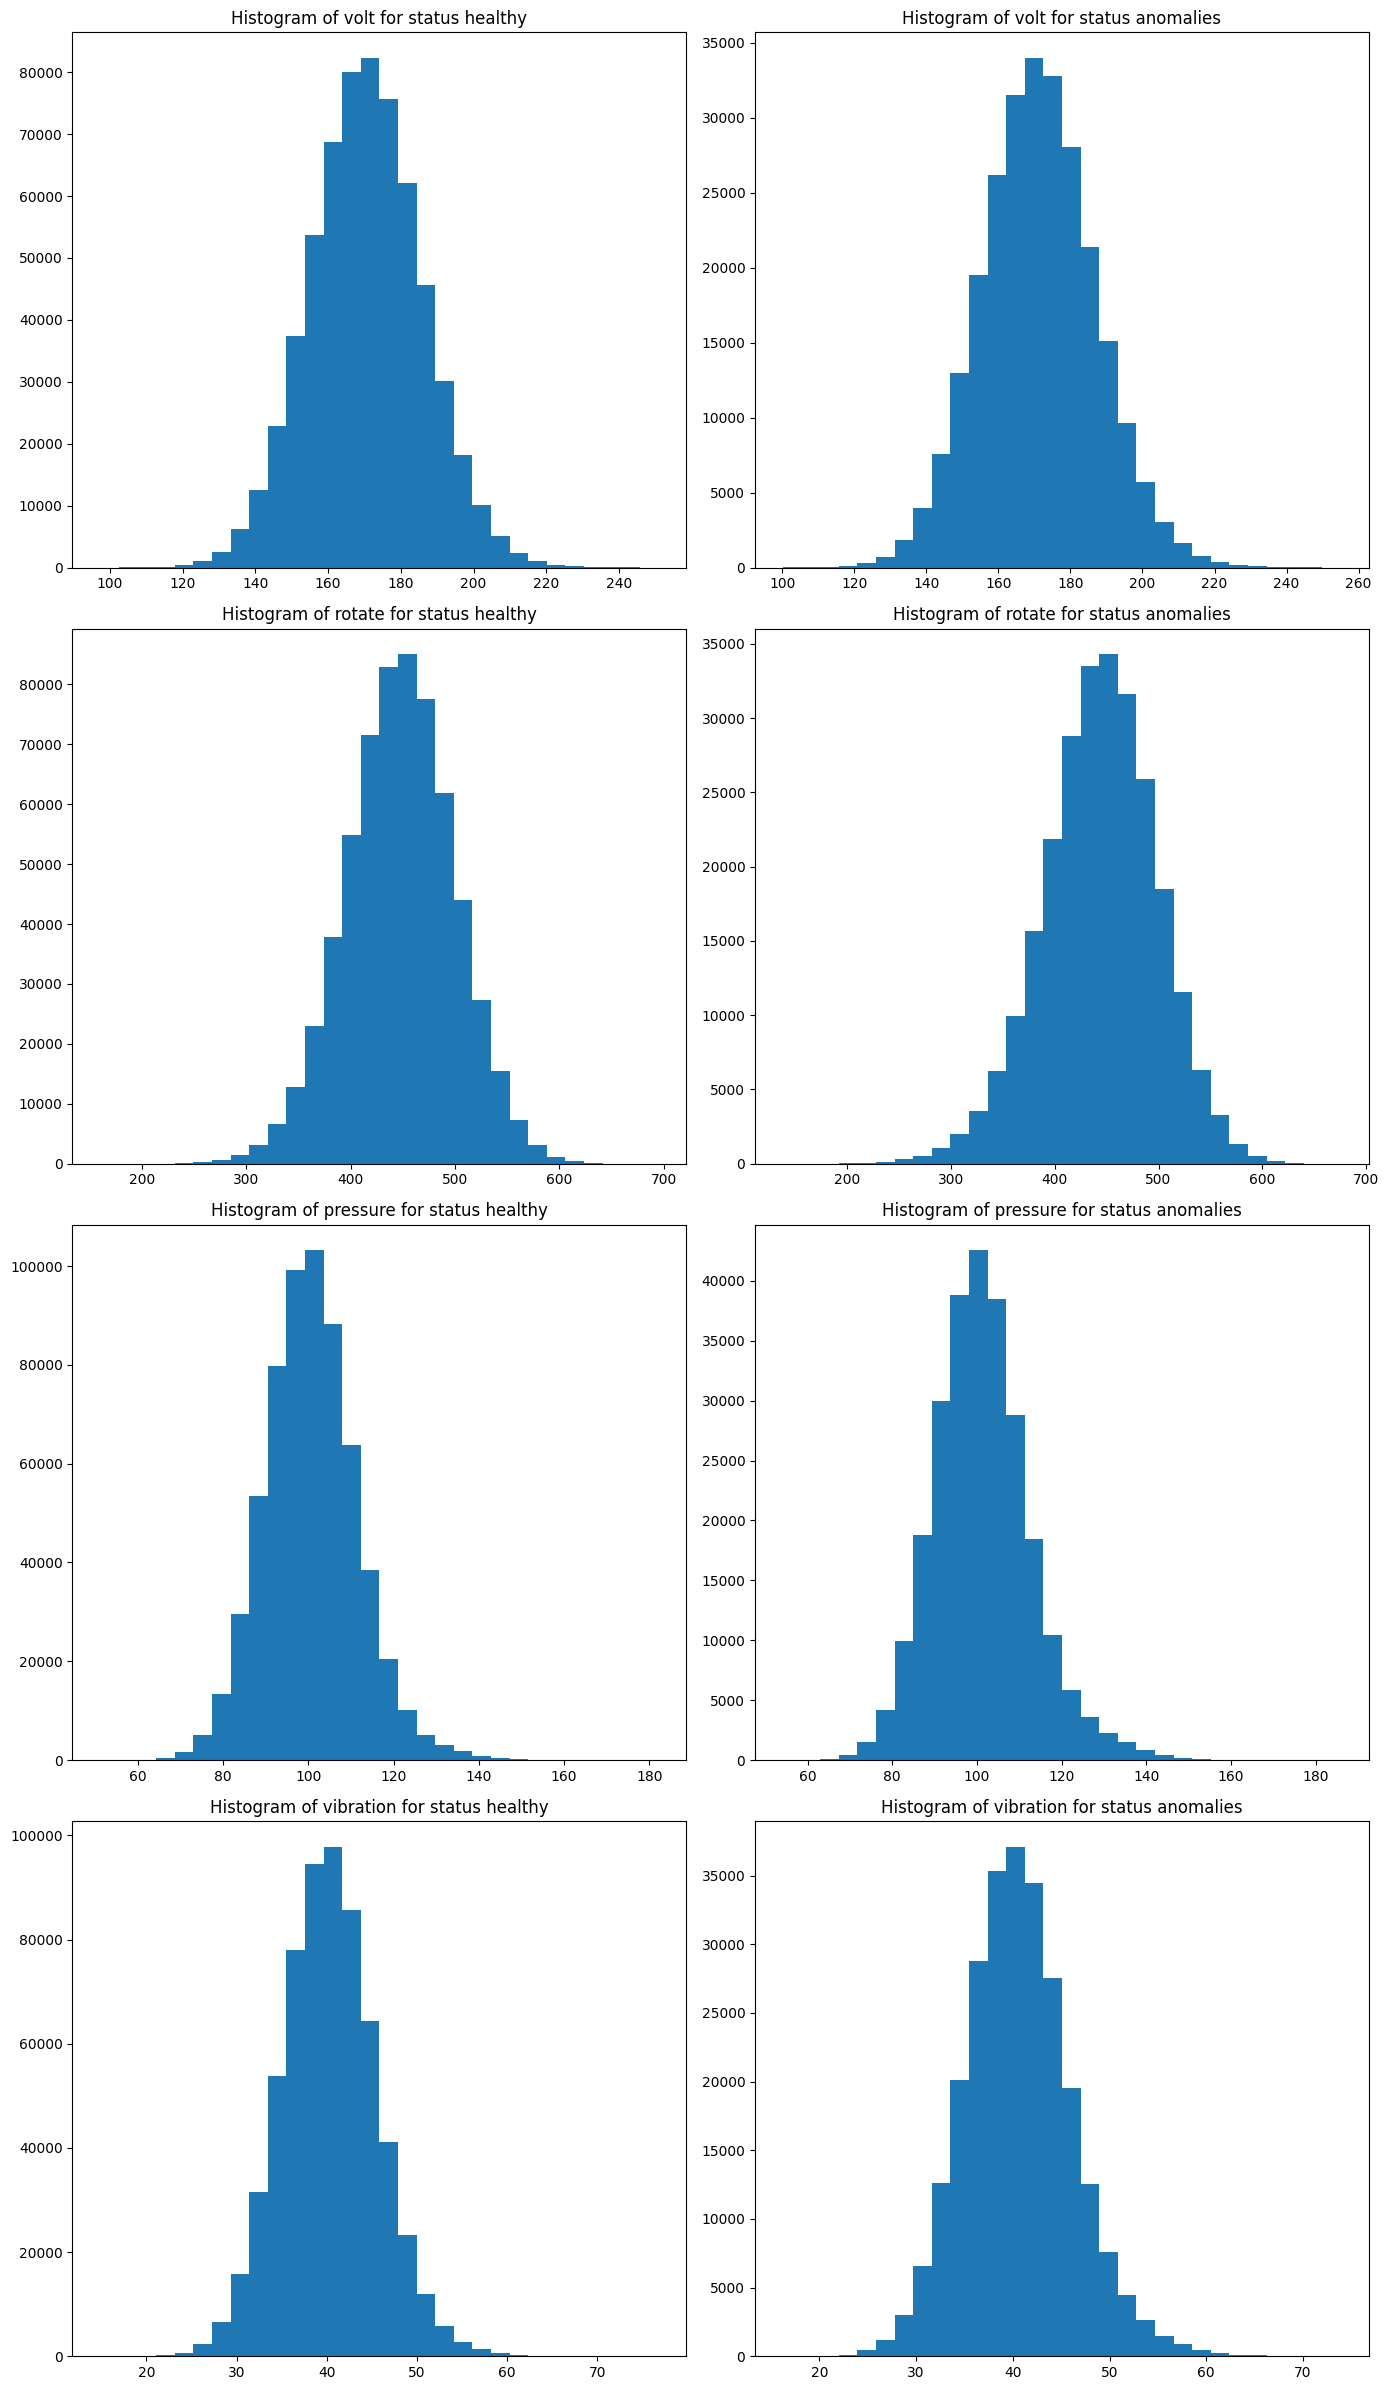

In [16]:
split_data = combined_data[(combined_data["status"] != "before_removal")]

fig, axes = plt.subplots(len(VARIABLES), 2, figsize=(14, 6 * len(VARIABLES)))
statuses = split_data["status"].unique()

for ax_row, variable in zip(axes, VARIABLES):
    for ax, status in zip(ax_row, statuses):
        data = split_data[split_data["status"] == status][variable]
        ax.hist(data.dropna(), bins=30)
        ax.set_title(f"Histogram of {variable} for status {status}")

plt.tight_layout()
plt.show()

#### Standardized plot

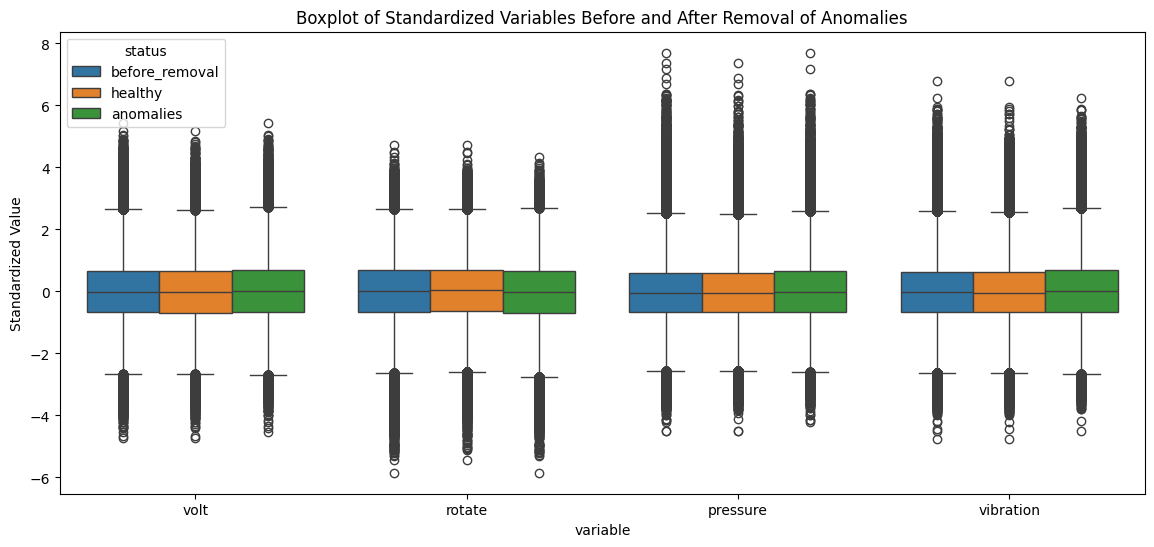

In [17]:
from sklearn.preprocessing import StandardScaler

# Standardize the variables
scaler = StandardScaler()
standard_data = combined_data.copy()
standard_data[VARIABLES] = scaler.fit_transform(combined_data[VARIABLES])

# Melt the DataFrame
melted_data = pd.melt(
    standard_data, id_vars=["machineID", "status"], value_vars=VARIABLES
)

# Create the boxplot
plt.figure(figsize=(14, 6))
sns.boxplot(x="variable", y="value", hue="status", data=melted_data)
plt.title("Boxplot of Standardized Variables Before and After Removal of Anomalies")
plt.ylabel("Standardized Value")
plt.show()

## Graphs for individual machines

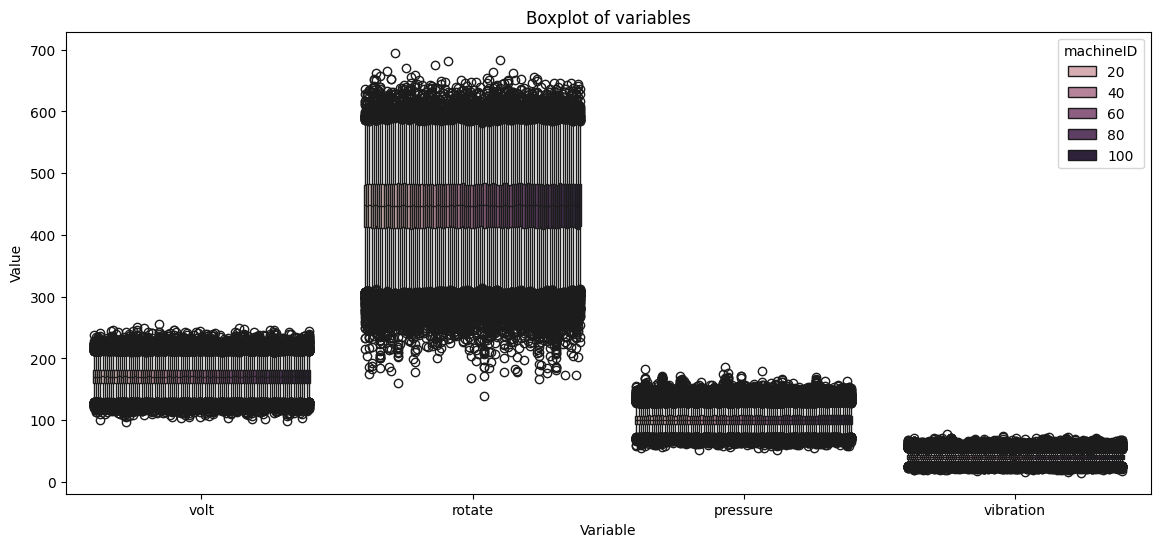

In [18]:
melted_data = pd.melt(DATA, id_vars=["datetime", "machineID"], value_vars=VARIABLES)

plt.figure(figsize=(14, 6))
sns.boxplot(x="variable", y="value", hue="machineID", data=melted_data)
plt.title("Boxplot of variables")
plt.xlabel("Variable")
plt.ylabel("Value")
plt.show()

#### Standardization for individual machines

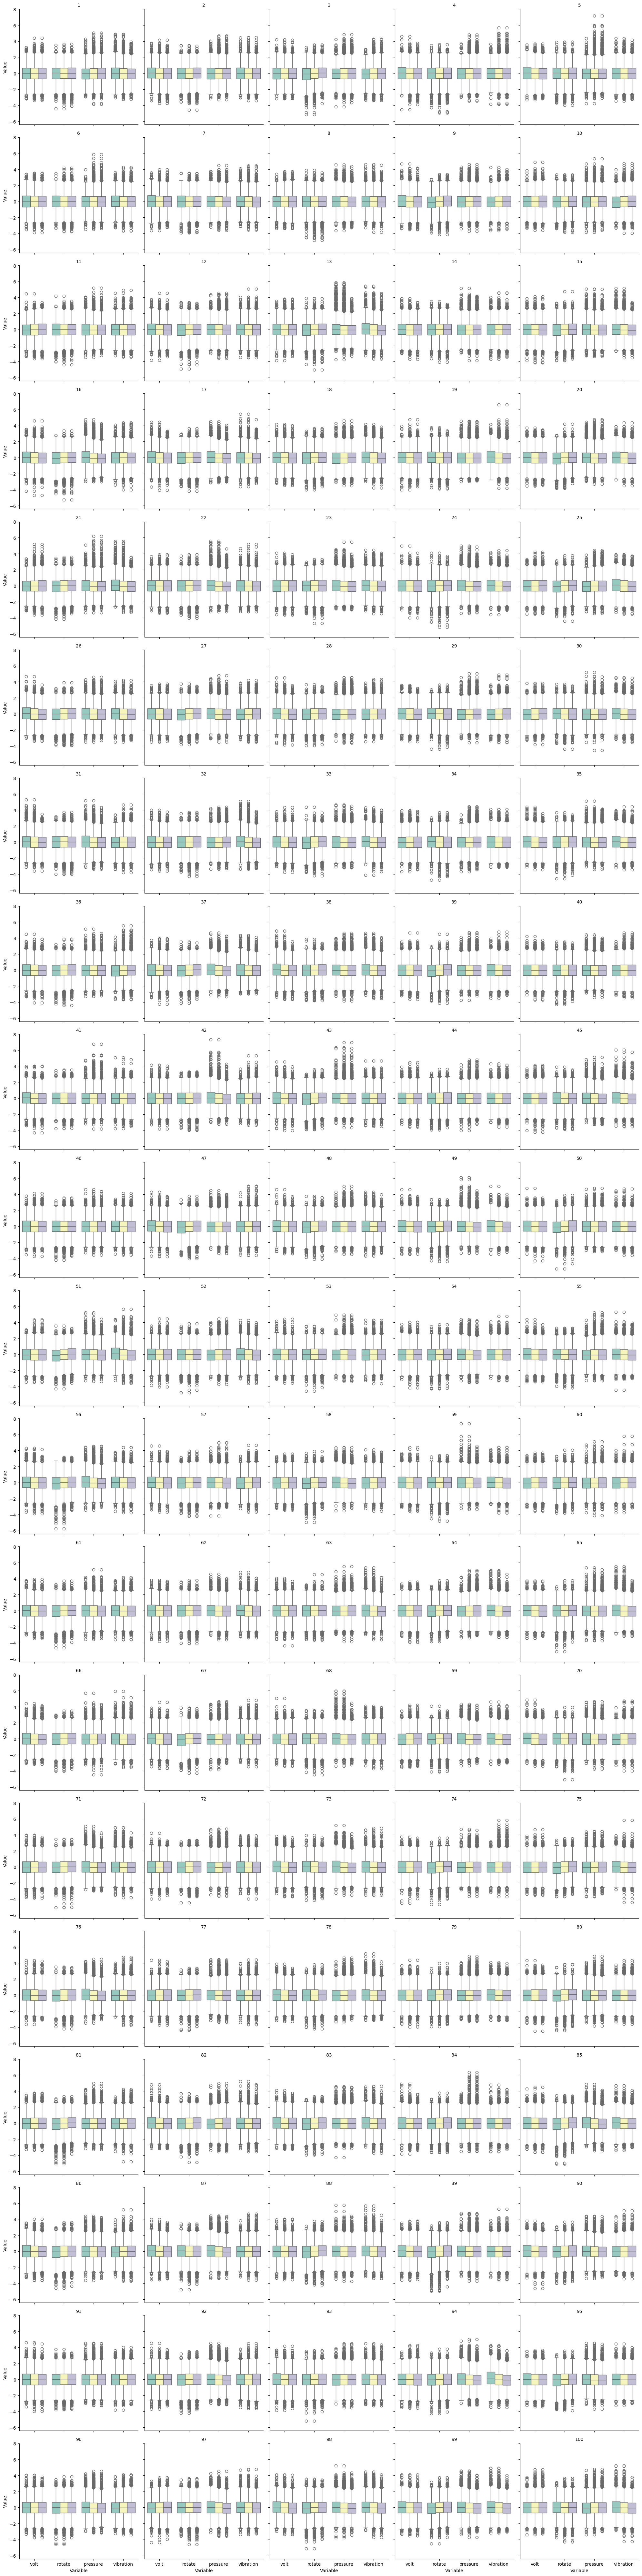

In [19]:
# Standardize values for each 'machineID'
standard_data = combined_data.copy()
for variable in VARIABLES:
    standard_data[variable] = combined_data.groupby("machineID")[variable].transform(
        lambda x: (x - x.mean()) / x.std()
    )
melted_data = pd.melt(
    standard_data, id_vars=["machineID", "status"], value_vars=VARIABLES
)

# Create a FacetGrid with 'machineID' on the columns
g = sns.FacetGrid(melted_data, col="machineID", col_wrap=5, height=4, aspect=1)

# Get the unique status values and sort them
status_values = sorted(melted_data["status"].unique())

# Map a boxplot onto each subplot
g.map(
    sns.boxplot,
    "variable",
    "value",
    "status",
    palette="Set3",
    order=VARIABLES,
    hue_order=status_values,
)
g.set_titles("{col_name}")
g.set_axis_labels("Variable", "Value")
plt.show()

### Distribution of data

Only shown the first machine as an example from now on.

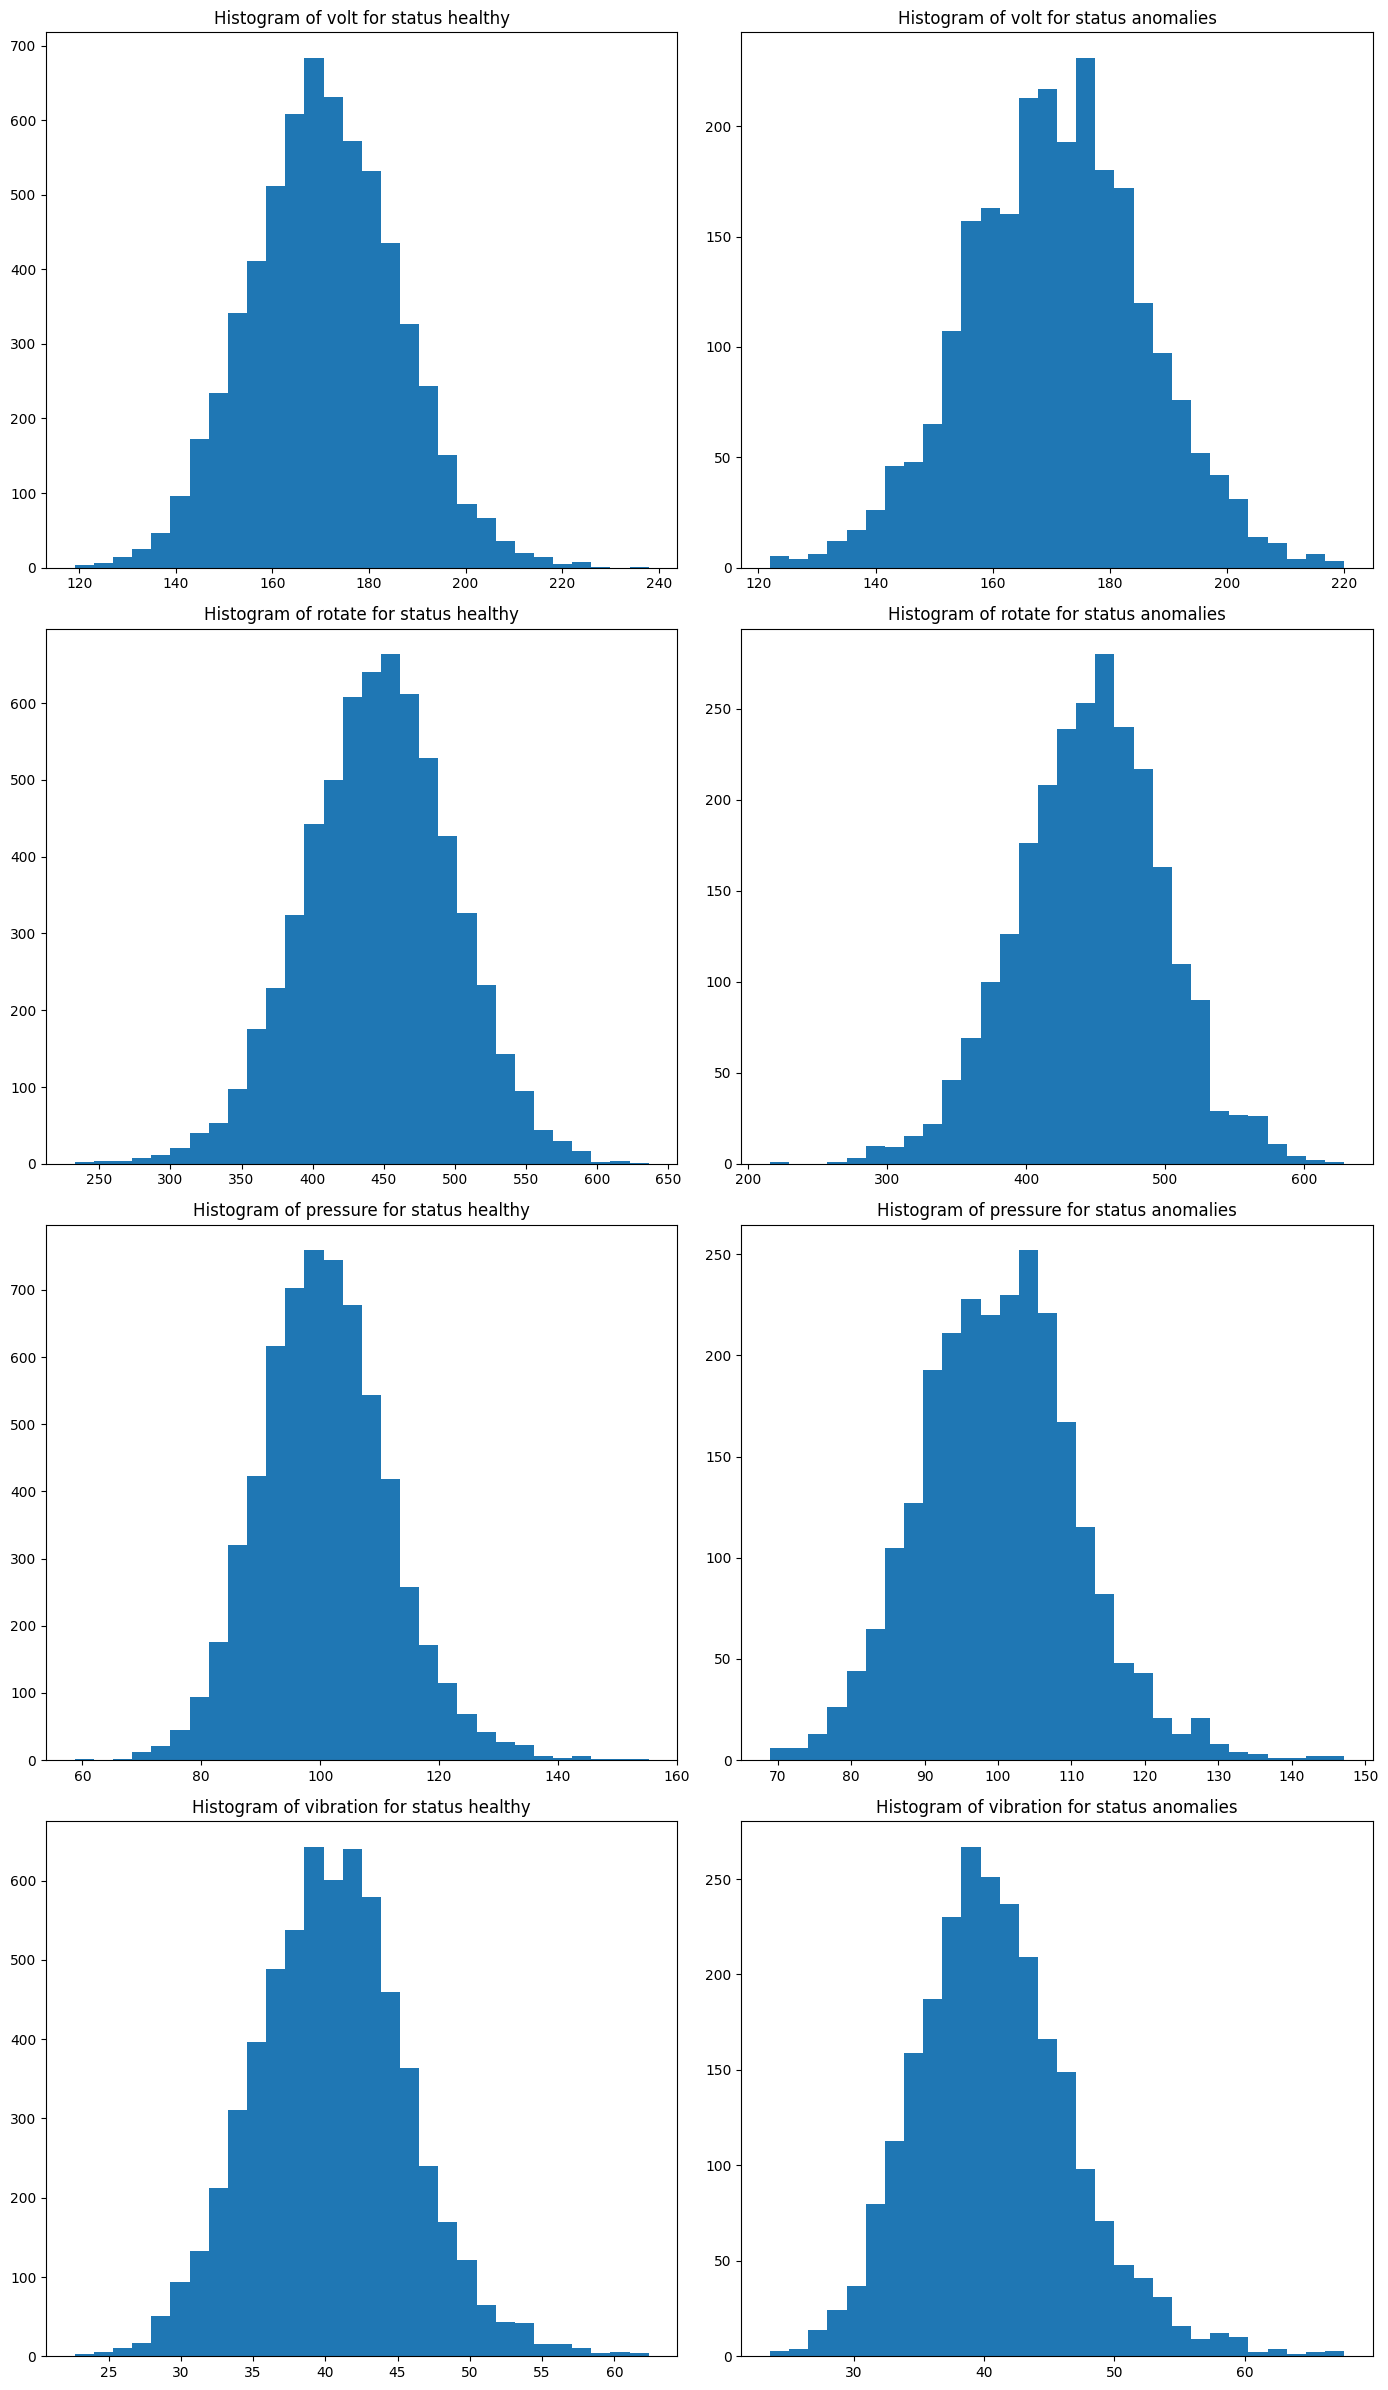

In [20]:
first_machine_data = combined_data[
    (combined_data["machineID"] == combined_data["machineID"].min())
    & (combined_data["status"] != "before_removal")
]

first_machine_std = standard_data[
    (standard_data["machineID"] == standard_data["machineID"].min())
    & (standard_data["status"] != "before_removal")
]

fig, axes = plt.subplots(len(VARIABLES), 2, figsize=(14, 6 * len(VARIABLES)))
statuses = first_machine_data["status"].unique()

for ax_row, variable in zip(axes, VARIABLES):
    for ax, status in zip(ax_row, statuses):
        data = first_machine_data[first_machine_data["status"] == status][variable]
        ax.hist(data.dropna(), bins=30)
        ax.set_title(f"Histogram of {variable} for status {status}")

plt.tight_layout()
plt.show()

### Time series plot for individual machines

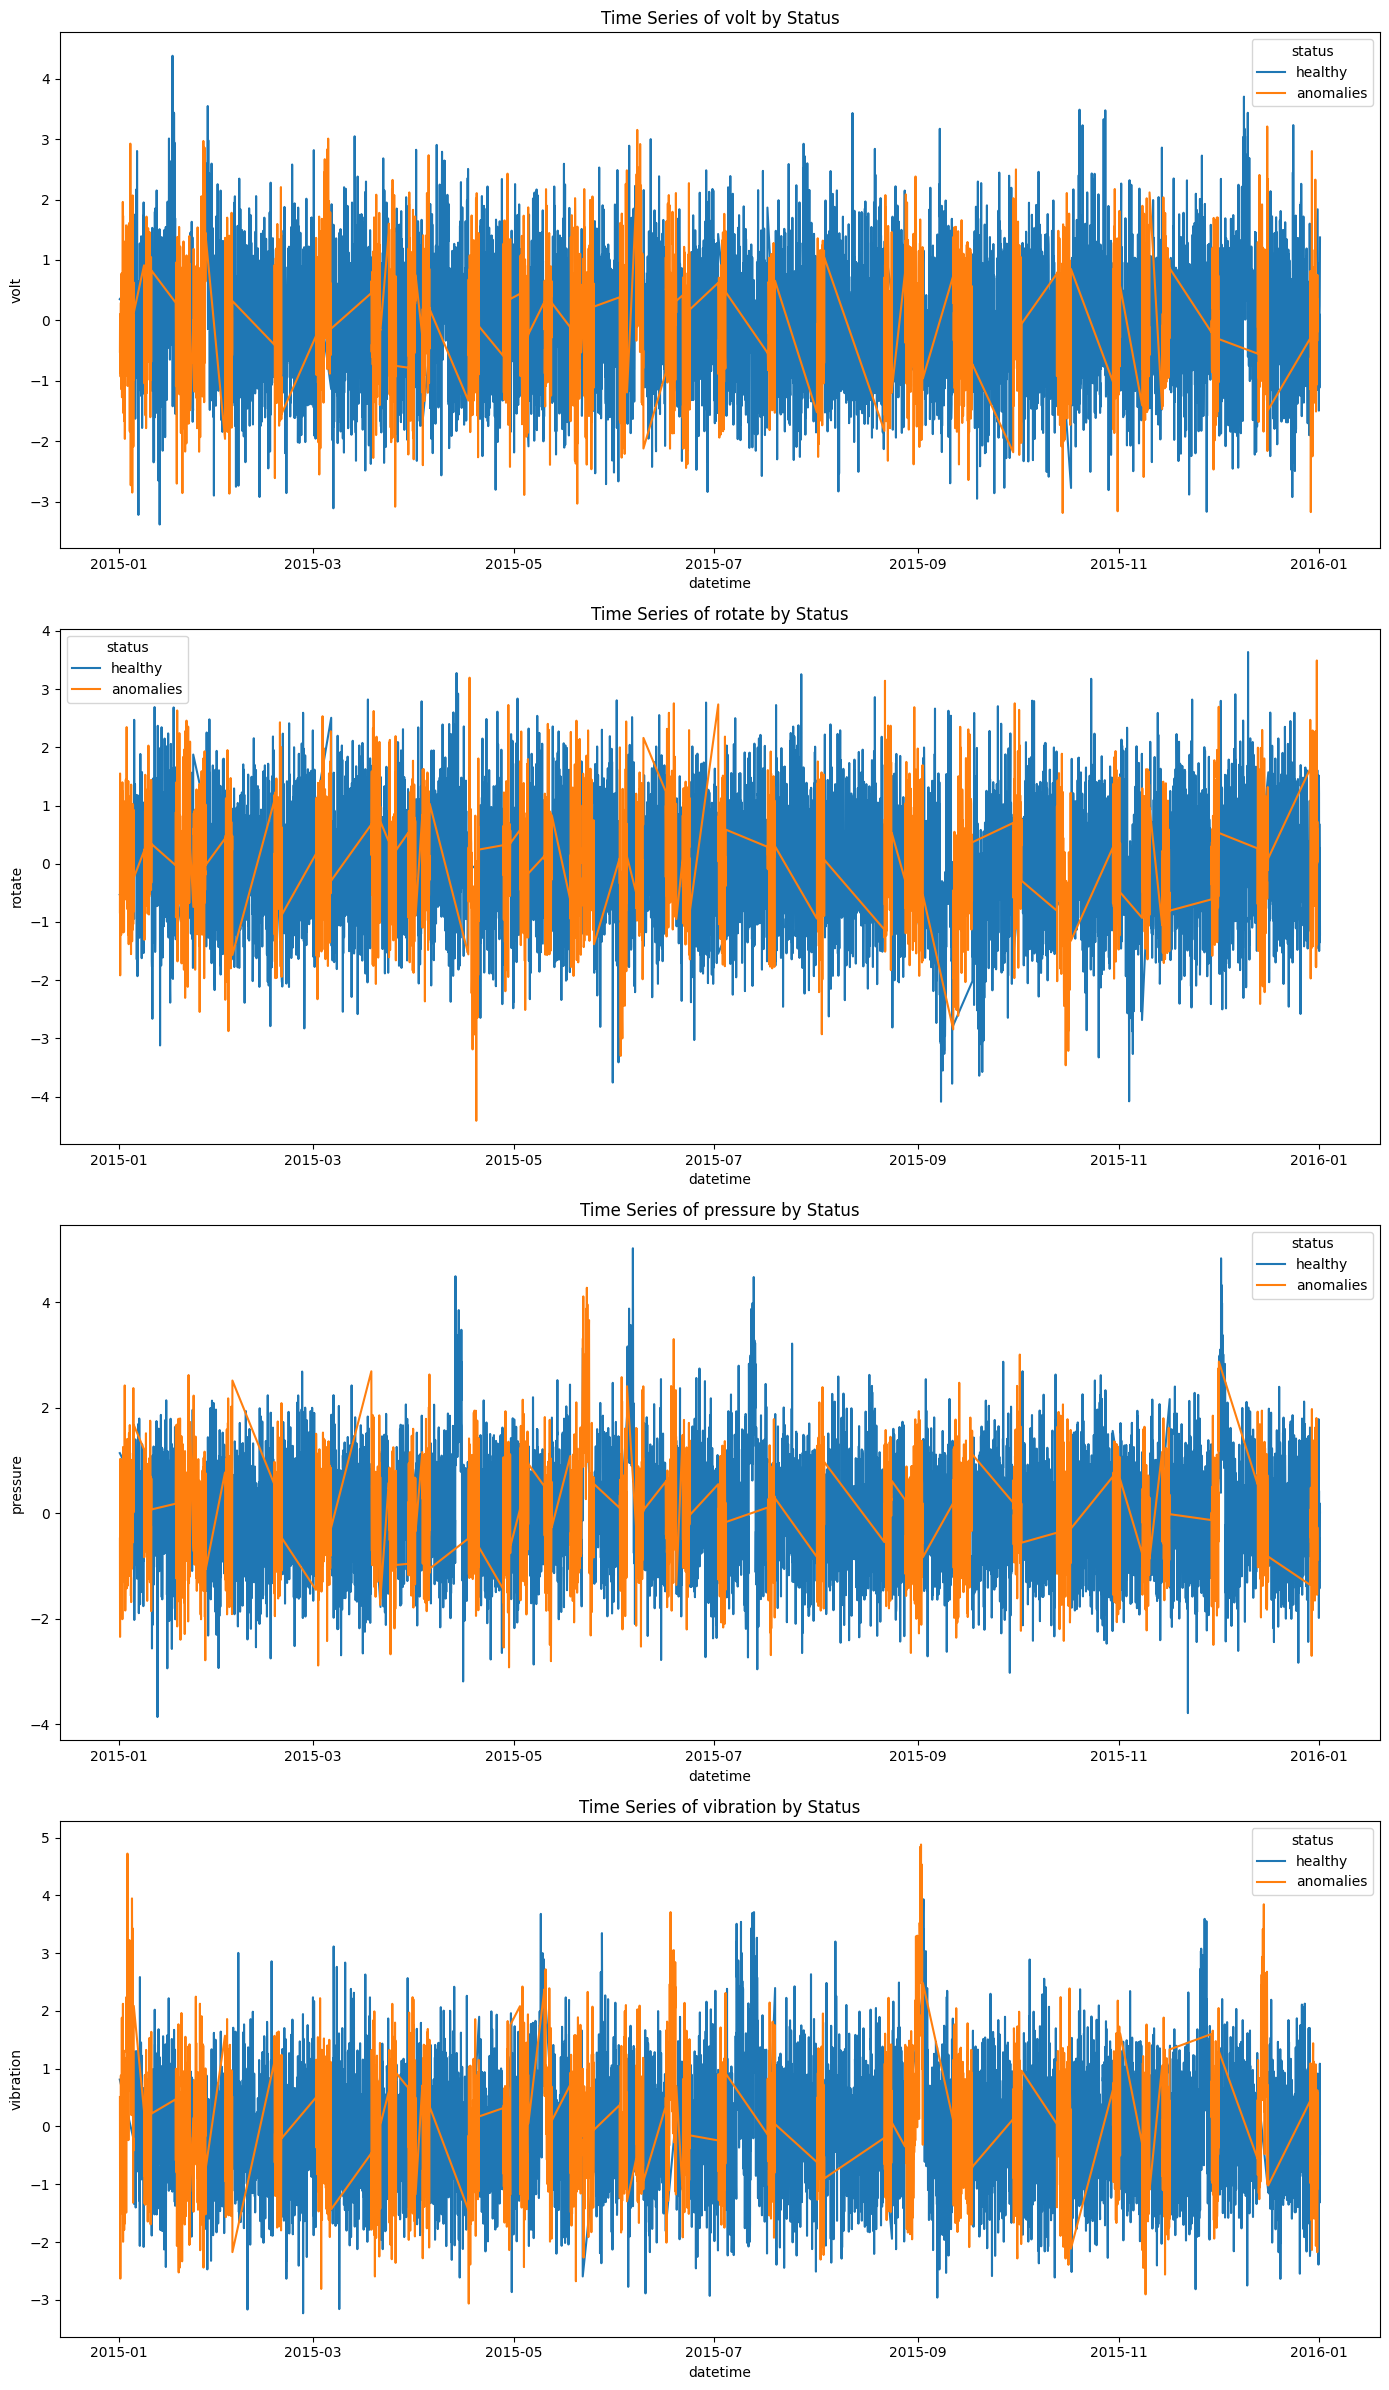

In [21]:
fig, axes = plt.subplots(len(VARIABLES), figsize=(14, 6 * len(VARIABLES)))
for ax, variable in zip(axes, VARIABLES):
    sns.lineplot(x="datetime", y=variable, hue="status", data=first_machine_std, ax=ax)
    ax.set_title(f"Time Series of {variable} by Status")
plt.tight_layout()
plt.show()

#### Removing noise from the data

- Rolling mean

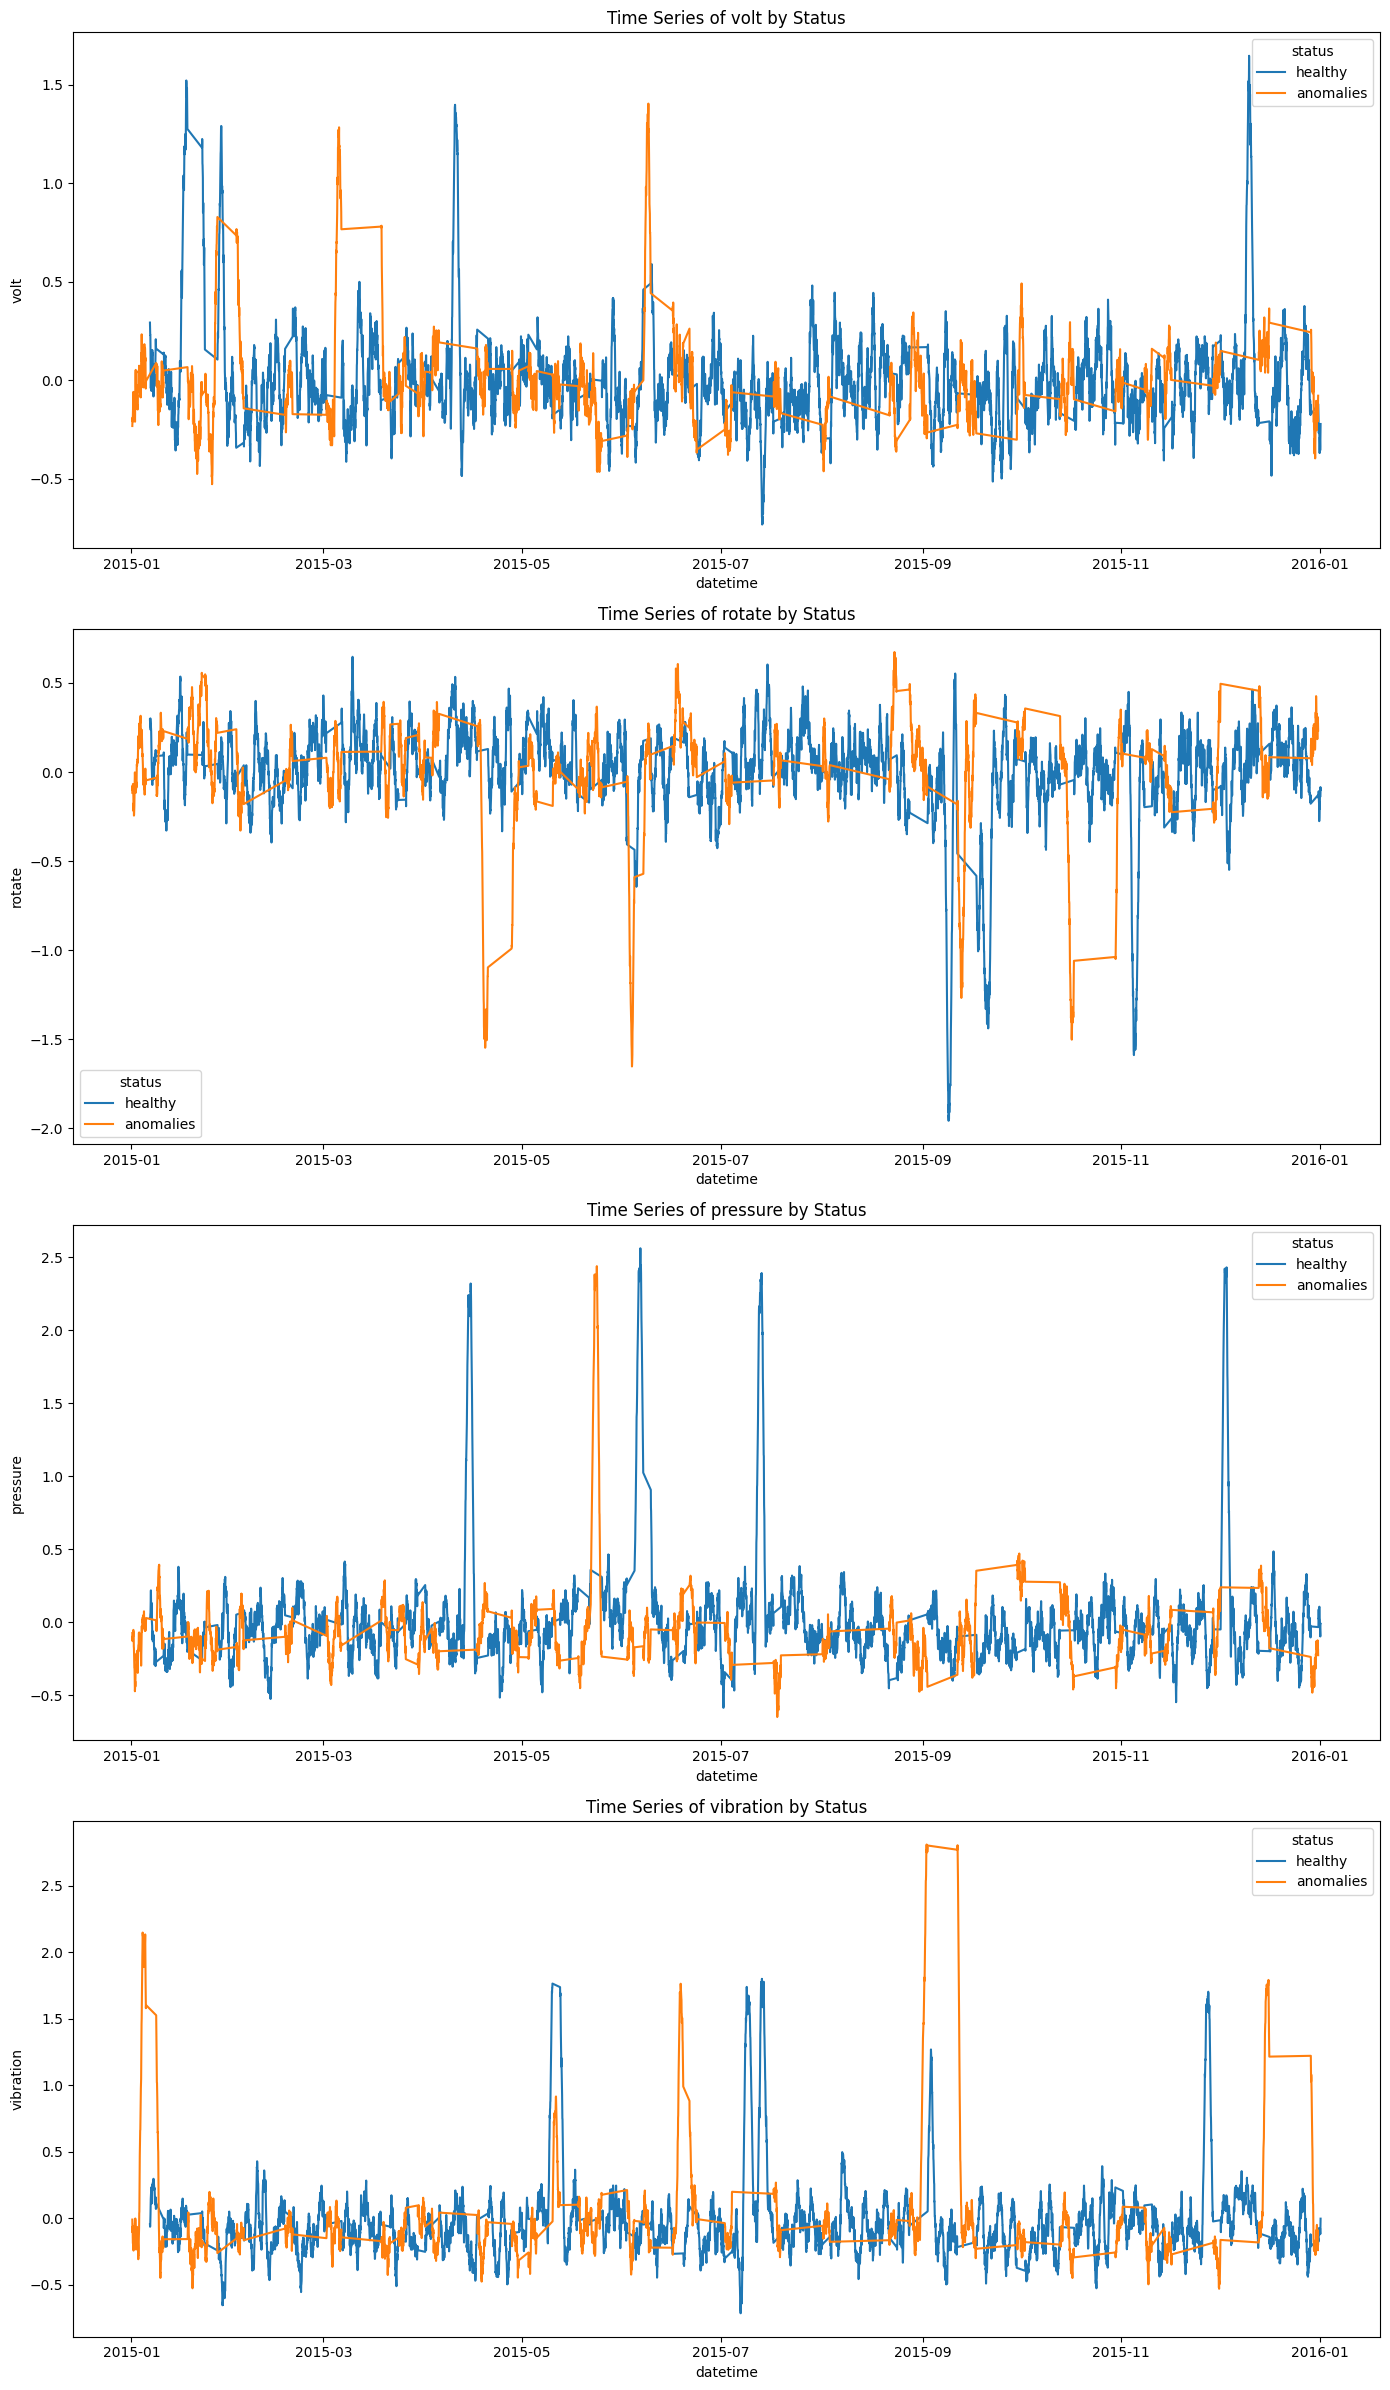

In [22]:
window_size = 30
first_machine_smooth = first_machine_std.copy()

for variable in VARIABLES:
    first_machine_smooth[variable] = (
        first_machine_smooth[variable].rolling(window_size).mean()
    )
    
first_machine_smooth = first_machine_smooth.reset_index(drop=True)

fig, axes = plt.subplots(len(VARIABLES), figsize=(14, 6 * len(VARIABLES)))
for ax, variable in zip(axes, VARIABLES):
    sns.lineplot(
        x="datetime", y=variable, hue="status", data=first_machine_smooth, ax=ax
    )
    ax.set_title(f"Time Series of {variable} by Status")
plt.tight_layout()
plt.show()

- Exponential smoothing

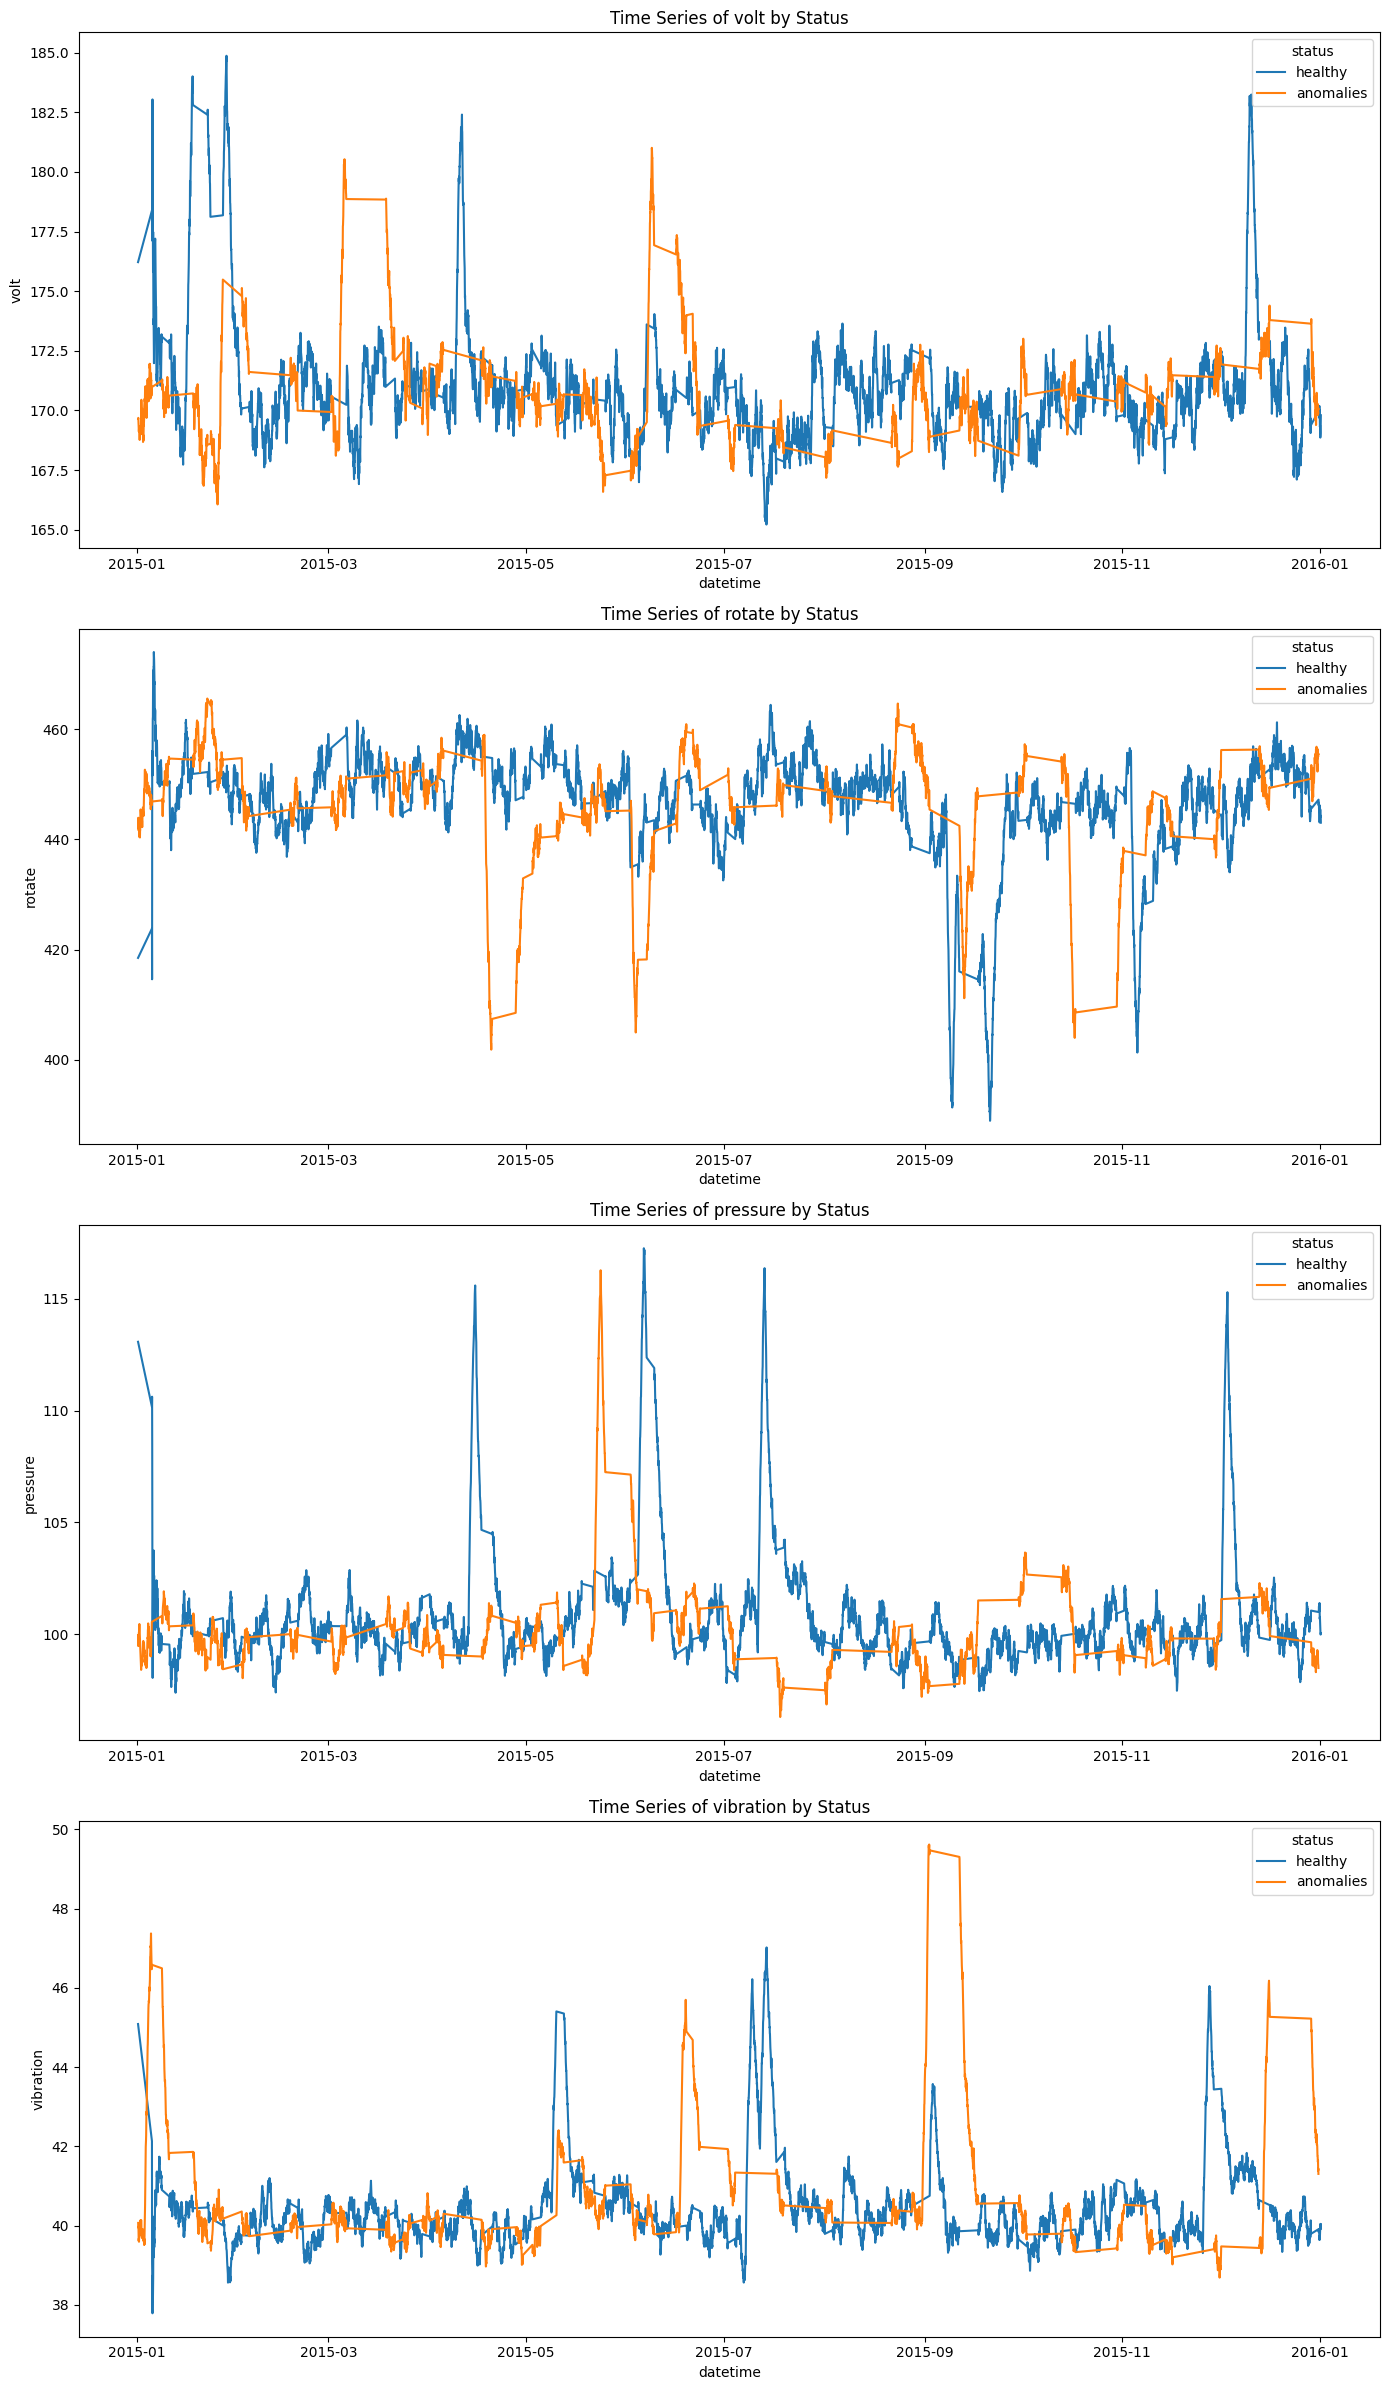

In [23]:
alpha = 0.02
first_machine_data_smooth = first_machine_data.copy()

for variable in VARIABLES:
    first_machine_data_smooth[variable] = (
        first_machine_data_smooth[variable].ewm(alpha=alpha).mean()
    )

fig, axes = plt.subplots(len(VARIABLES), figsize=(14, 6 * len(VARIABLES)))
for ax, variable in zip(axes, VARIABLES):
    sns.lineplot(
        x="datetime", y=variable, hue="status", data=first_machine_data_smooth, ax=ax
    )
    ax.set_title(f"Time Series of {variable} by Status")
plt.tight_layout()
plt.show()